In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
plt.rc('font', family='NanumBarunGothic')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/merge_df.csv',encoding='utf-8-sig')
df

,기준_년분기_코드,점포_수,유사_업종_점포_수,개업_율,개업_점포_수,폐업_률,폐업_점포_수,프랜차이즈_점포_수,상권_라벨,서비스_라벨,...,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,변화_지표,행정동_라벨,동별_임대료
0,20211,4,4,0,0,0,0,0,363,57,...,7797.0,734.0,3456.0,5594.0,5993.0,1896.0,734.0,0,180,60414.0
1,20211,7,11,9,1,0,0,4,1086,5,...,20443.0,681.0,14377.0,7024.0,4853.0,4659.0,1091.0,3,284,69241.0
2,20211,4,4,25,1,0,0,0,716,78,...,1139.0,0.0,12.0,168.0,613.0,622.0,227.0,0,180,60414.0
3,20211,29,29,17,5,0,0,0,499,99,...,45.0,0.0,0.0,0.0,0.0,0.0,45.0,1,113,97587.0
4,20211,7,8,0,0,0,0,1,801,10,...,414.0,0.0,0.0,38.0,548.0,256.0,0.0,3,131,72479.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229410,20234,3,3,0,0,0,0,0,99,65,...,18548.0,26.0,766.0,3490.0,5592.0,6505.0,12047.0,2,16,152259.0
229411,20234,4,4,0,0,0,0,0,99,66,...,1699.0,27.0,242.0,738.0,895.0,634.0,677.0,2,16,152259.0
229412,20234,6,6,17,1,0,0,0,99,67,...,1757.0,0.0,224.0,373.0,698.0,386.0,274.0,2,16,152259.0
229413,20234,5,5,0,0,0,0,0,99,74,...,121970.0,1124.0,13622.0,45059.0,64597.0,43247.0,64390.0,2,16,152259.0


In [ ]:
# label_df = df[['기준_년분기_코드','상권_라벨','서비스_라벨','행정동_라벨']]
label_df = df[['기준_년분기_코드']]
label_df.head()

,기준_년분기_코드
0,20211
1,20211
2,20211
3,20211
4,20211


In [ ]:
# df = df.drop(columns=['기준_년분기_코드','상권_라벨','서비스_라벨','행정동_라벨'])
df = df.drop(columns=['기준_년분기_코드'])
df

,점포_수,유사_업종_점포_수,개업_율,개업_점포_수,폐업_률,폐업_점포_수,프랜차이즈_점포_수,상권_라벨,서비스_라벨,총_유동인구_수,...,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,변화_지표,행정동_라벨,동별_임대료
0,4,4,0,0,0,0,0,363,57,1012055.0,...,7797.0,734.0,3456.0,5594.0,5993.0,1896.0,734.0,0,180,60414.0
1,7,11,9,1,0,0,4,1086,5,421517.0,...,20443.0,681.0,14377.0,7024.0,4853.0,4659.0,1091.0,3,284,69241.0
2,4,4,25,1,0,0,0,716,78,1579369.0,...,1139.0,0.0,12.0,168.0,613.0,622.0,227.0,0,180,60414.0
3,29,29,17,5,0,0,0,499,99,1819817.0,...,45.0,0.0,0.0,0.0,0.0,0.0,45.0,1,113,97587.0
4,7,8,0,0,0,0,1,801,10,4199153.0,...,414.0,0.0,0.0,38.0,548.0,256.0,0.0,3,131,72479.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229410,3,3,0,0,0,0,0,99,65,122487.0,...,18548.0,26.0,766.0,3490.0,5592.0,6505.0,12047.0,2,16,152259.0
229411,4,4,0,0,0,0,0,99,66,122487.0,...,1699.0,27.0,242.0,738.0,895.0,634.0,677.0,2,16,152259.0
229412,6,6,17,1,0,0,0,99,67,122487.0,...,1757.0,0.0,224.0,373.0,698.0,386.0,274.0,2,16,152259.0
229413,5,5,0,0,0,0,0,99,74,122487.0,...,121970.0,1124.0,13622.0,45059.0,64597.0,43247.0,64390.0,2,16,152259.0


In [ ]:
# 데이터 준비
X = df.drop(columns=['당월_매출_금액'])  # 독립 변수
y = df['당월_매출_금액']  # 종속 변수

# '매출'이 포함되지 않은 컬럼만 선택 (선택적)
X = X.loc[:, ~X.columns.str.contains("매출")]

# 학습 데이터 & 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 테스트 데이터 인덱스 정리
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

## XGBOOST

In [ ]:
# XGBoost 모델 생성
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',  # 회귀 문제
    n_estimators=1000,  # 트리 개수
    learning_rate=0.05,  # 학습률
    min_child_weight=10,  # 리프 노드의 최소 샘플 수 설정
    max_depth=6,  # 트리 깊이
    subsample=0.8,  # 샘플링 비율
    colsample_bytree=0.8,  # 피처 샘플링 비율
    random_state=42,
    alpha=0.1,   # L1 정규화
    reg_lambda = 1# L2 정규화
)

# 모델 학습
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_test, y_test)],
            verbose=False)
# 예측 수행
y_pred = xgb_reg.predict(X_test)

# 성능 평가
xgb_r2 = r2_score(y_test, y_pred)
xgb_mse = mean_squared_error(y_test, y_pred)
xgb_mae = mean_absolute_error(y_test, y_pred)
xgb_mape = mean_absolute_percentage_error(y_test, y_pred)
xgb_rmse = np.sqrt(xgb_mse)

print(f" R-squared (R²): {xgb_r2:.4f}")
print(f" Mean Absolute Error (MAE): {xgb_mae:.2f}")
print(f" Mean Absolute Percentage Error (MAPE): {xgb_mape:.4f}")
print(f" Mean Squared Error (MSE): {xgb_mse:.2f}")
print(f" Root Mean Squared Error (MSE): {xgb_rmse:.2f}")

 R-squared (R²): 0.9398
 Mean Absolute Error (MAE): 482295968.00
 Mean Absolute Percentage Error (MAPE): 169.6538
 Mean Squared Error (MSE): 3715266832685334528.00
 Root Mean Squared Error (MSE): 1927502745.18


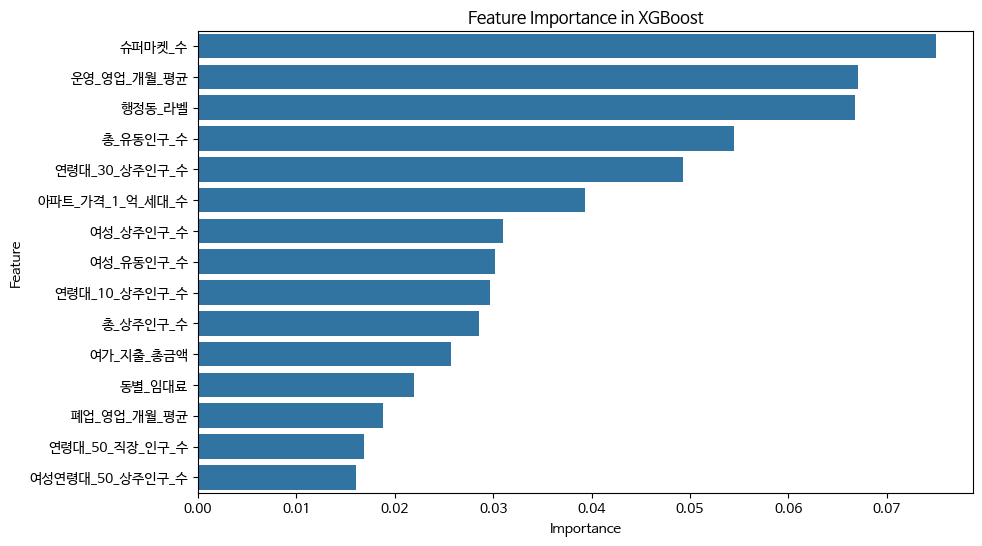

In [ ]:
xgb_fi = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_reg.feature_importances_
})

# 내림차순으로 정렬
xgb_fi = xgb_fi.sort_values(by='Importance', ascending=False)

# Feature 중요도 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=xgb_fi.iloc[:15])
plt.title("Feature Importance in XGBoost")
plt.show()

In [ ]:
xgb_top10 = xgb_fi['Feature'][:10].tolist()
xgb_top10

['슈퍼마켓_수',
 '운영_영업_개월_평균',
 '행정동_라벨',
 '총_유동인구_수',
 '연령대_30_상주인구_수',
 '아파트_가격_1_억_세대_수',
 '여성_상주인구_수',
 '여성_유동인구_수',
 '연령대_10_상주인구_수',
 '총_상주인구_수']

In [ ]:
param_grid = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.03, 0.05, 0.07],
    'max_depth': [4, 6, 8],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [5, 10, 15],
    'alpha': [0.05, 0.1, 0.2],
    'reg_lambda': [0.5, 1, 2]
}

In [ ]:
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(estimator=xgb_reg,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error', # 평가지표, 회귀문제이므로 neg_mean_squared_error로 설정
                           cv=3, # 교차 검증 분할 수
                           verbose=1)

grid_search.fit(X_train, y_train)

best_xgb_reg = grid_search.best_estimator_

In [ ]:
y_pred = best_xgb_reg.predict(X_test)

xgb_r2 = r2_score(y_test, y_pred)
xgb_mse = mean_squared_error(y_test, y_pred)
xgb_mae = mean_absolute_error(y_test, y_pred)
xgb_mape = mean_absolute_percentage_error(y_test, y_pred)
xgb_rmse = np.sqrt(xgb_mse)

print(f"Best Parameters: {grid_search.best_params_}")
print(f" R-squared (R²): {xgb_r2:.4f}")
print(f" Mean Absolute Error (MAE): {xgb_mae:.2f}")
print(f" Mean Absolute Percentage Error (MAPE): {xgb_mape:.4f}")
print(f" Mean Squared Error (MSE): {xgb_mse:.2f}")
print(f" Root Mean Squared Error (MSE): {xgb_rmse:.2f}")

## RandomForest

In [ ]:
# RandomForest 모델 생성
rf_reg = RandomForestRegressor(
    n_estimators=10,  # 트리 개수
    random_state=42,
    n_jobs=-1  # 모든 CPU 코어를 사용하여 병렬 처리
)

# 모델 학습
rf_reg.fit(X_train, y_train)

# 예측 수행
y_pred = rf_reg.predict(X_test)

# 성능 평가
rf_r2 = r2_score(y_test, y_pred)
rf_mse = mean_squared_error(y_test, y_pred)
rf_mae = mean_absolute_error(y_test, y_pred)
rf_mape = mean_absolute_percentage_error(y_test, y_pred)

print(f" R-squared (R²): {rf_r2:.4f}")
print(f" Mean Absolute Error (MAE): {rf_mae:.2f}")
print(f" Mean Absolute Percentage Error (MAPE): {rf_mape:.4f}")
print(f" Mean Squared Error (MSE): {rf_mse:.2f}")

 R-squared (R²): 0.9095
 Mean Absolute Error (MAE): 218869062.56
 Mean Absolute Percentage Error (MAPE): 142.1057
 Mean Squared Error (MSE): 5584675625135849472.00


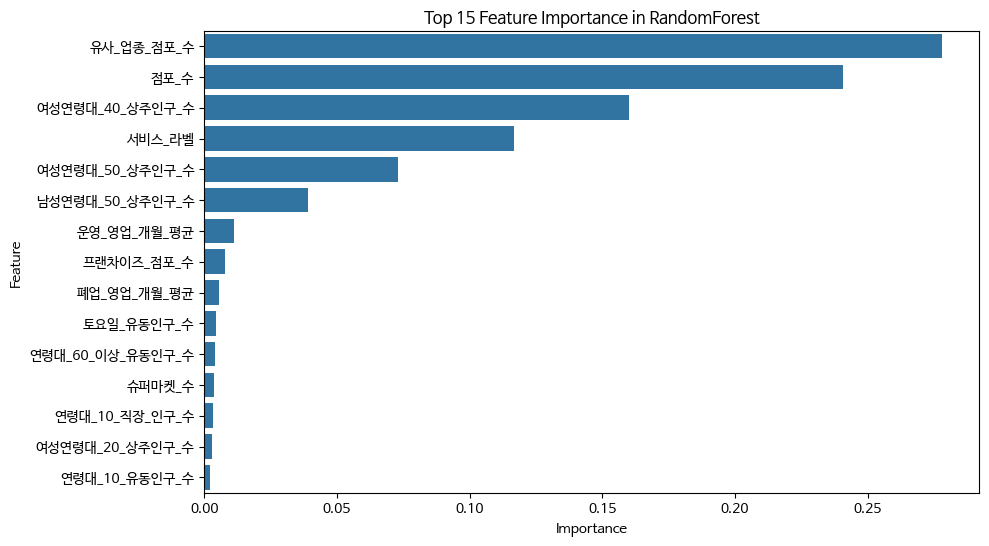

In [ ]:
# Feature 중요도 추출
rf_fi = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_reg.feature_importances_
})

# 중요도 내림차순으로 정렬
rf_fi = rf_fi.sort_values(by='Importance', ascending=False)

# 상위 15개 중요 피처만 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rf_fi.iloc[:15])
plt.title("Top 15 Feature Importance in RandomForest")
plt.show()

In [ ]:
rf_top10 = rf_fi.iloc[:10]['Feature'].tolist()
rf_top10

['유사_업종_점포_수',
 '점포_수',
 '여성연령대_40_상주인구_수',
 '서비스_라벨',
 '여성연령대_50_상주인구_수',
 '남성연령대_50_상주인구_수',
 '운영_영업_개월_평균',
 '프랜차이즈_점포_수',
 '폐업_영업_개월_평균',
 '토요일_유동인구_수']

In [ ]:
top_df = df[list(set(xgb_top10 + rf_top10+['당월_매출_금액']))]
top_df.head()

,연령대_10_상주인구_수,프랜차이즈_점포_수,총_상주인구_수,아파트_가격_1_억_세대_수,토요일_유동인구_수,여성연령대_40_상주인구_수,점포_수,슈퍼마켓_수,유사_업종_점포_수,남성연령대_50_상주인구_수,여성연령대_50_상주인구_수,운영_영업_개월_평균,당월_매출_금액,서비스_라벨,여성_상주인구_수,여성_유동인구_수,폐업_영업_개월_평균,총_유동인구_수,행정동_라벨,연령대_30_상주인구_수
0,156,0,1338,133,145030,92,4,0,4,111,121,105,109968767,57,677,542580,57,1012055,180,173
1,246,4,2247,38,60972,160,7,0,11,179,161,83,351216505,5,1224,227943,49,421517,284,329
2,256,0,2693,67,232794,156,4,0,4,286,239,129,450674105,78,1323,864285,51,1579369,180,276
3,471,0,4806,547,266033,355,29,0,29,401,454,105,9000000,99,2499,999100,45,1819817,113,679
4,788,1,7975,683,604337,586,7,0,8,685,614,85,256980012,10,3955,2219971,41,4199153,131,1134


In [ ]:
top_x = top_df.drop(columns=['당월_매출_금액'])
top_y = top_df['당월_매출_금액']

top_x_train, top_x_test, top_y_train, top_y_test = train_test_split(top_x,top_y,test_size=0.3, random_state=42)

In [ ]:
# XGBoost 모델 생성
top_xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',  # 회귀 문제
    n_estimators=1000,  # 트리 개수
    learning_rate=0.05,  # 학습률
    min_child_weight=10,  # 리프 노드의 최소 샘플 수 설정
    max_depth=6,  # 트리 깊이
    subsample=0.8,  # 샘플링 비율
    colsample_bytree=0.8,  # 피처 샘플링 비율
    random_state=42,
    alpha=0.1,   # L1 정규화
    reg_lambda = 1# L2 정규화
)

# 모델 학습
top_xgb_reg.fit(top_x_train, top_y_train)
# 예측 수행
y_pred = top_xgb_reg.predict(top_x_test)

# 성능 평가
xgb_r2 = r2_score(top_y_test, y_pred)
xgb_mse = mean_squared_error(top_y_test, y_pred)
xgb_mae = mean_absolute_error(top_y_test, y_pred)
xgb_mape = mean_absolute_percentage_error(top_y_test, y_pred)
xgb_rmse = np.sqrt(xgb_mse)

print(f" R-squared (R²): {xgb_r2:.4f}")
print(f" Mean Absolute Error (MAE): {xgb_mae:.2f}")
print(f" Mean Absolute Percentage Error (MAPE): {xgb_mape:.4f}")
print(f" Mean Squared Error (MSE): {xgb_mse:.2f}")
print(f" Root Mean Squared Error (MSE): {xgb_rmse:.2f}")

 R-squared (R²): 0.9466
 Mean Absolute Error (MAE): 459348736.00
 Mean Absolute Percentage Error (MAPE): 141.7665
 Mean Squared Error (MSE): 3293752832380895232.00
 Root Mean Squared Error (MSE): 1814869921.61


## 모델 저장

In [ ]:
def model_pickle(model, model_name):
    with open(f'{model_name}.pkl', 'wb') as f:
        pickle.dump(model, f)
    print(f"모델이 {model_name},pkl 파일로 저장되었습니다.")

In [ ]:
model_pickle(xgb_reg,'xgb_reg')
model_pickle(rf_reg,'rf_reg')

모델이 xgb_reg,pkl 파일로 저장되었습니다.
모델이 rf_reg,pkl 파일로 저장되었습니다.


In [ ]:
def load_pickle(model_name):
    with open(f'{model_name}.pkl', 'rb') as f:
        print(f"{model_name} 모델을 성공적으로 불러왔습니다.")
        return pickle.load(f)

In [ ]:
xgb_reg = load_pickle('xgb_reg')
rf_reg = load_pickle('rf_reg')

xgb_reg 모델을 성공적으로 불러왔습니다.
rf_reg 모델을 성공적으로 불러왔습니다.


In [ ]:
predictions = xgb_reg.predict(X_test.iloc[:1,:])
predictions

array([5.031182e+09], dtype=float32)